**Workflow illustrating the Kimeldorf–Wahba correspondence:**

  • Continuous setting → infinite-dimensional RKHS penalty ∫(f″)²  
  • Discretized on a grid of m points → finite-difference matrix D  
  • Precision operator P = DᵀD approximates the continuous penalty operator  
  • Penalized least squares (I + λP)⁻¹y = smoothing spline  
  • Algebraic identity shows that is also the GP posterior mean  
  • Posterior covariance = (I + λP)⁻¹ yields uncertainty bands  
  • Eigen-analysis confirms P ↔ covariance duality  


In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# 1. DATA GENERATION

# We discretize the interval [0,1] into m points.
# This turns an infinite-dimensional function problem into ℝᵐ.
# We generate y = f_true(x) + noise with known variance σ².

m = 200
x = np.linspace(0, 1, m)
f_true = np.sin(2 * np.pi * x)
sigma_noise = 0.2
rng = np.random.RandomState(42)
y = f_true + rng.normal(0, sigma_noise, size=m)

In [2]:
# 2. KIMELDORF–WAHBA SPLINE ESTIMATOR

# We discretize the continuous penalty ∫ (f″)² dx via a second-difference matrix D:
#   (Df)_i = f(x_{i+2}) − 2·f(x_{i+1}) + f(x_i)  ≈  f″(x_{i+1})·(Δx)²
# Here Df ≈ f″·(Δx)², so (Df)² ≈ f″²·(Δx)⁴.
# Thus fᵀP f = ∑(Df)² ≈ ∑[f″(x)]²·(Δx)⁴,
# up to the constant (Δx)⁴ which is absorbed into our choice of λ.

# The precision matrix P = DᵀD is our discrete analogue of the continuous
# operator LᵀL (where L = d²/dx²). We then solve the penalized‐LS system
#   (I + λ P) f_spline = y
# to obtain the smoothing‐spline estimate f_spline.

# Build finite‐difference D of shape (m−2)×m
D = np.zeros((m - 2, m))
for i in range(m - 2):
    D[i, i] = 1       # f(x_i)
    D[i, i + 1] = -2  # −2·f(x_{i+1})
    D[i, i + 2] = 1   # + f(x_{i+2})

P = D.T @ D  # Discrete precision operator
print("Operator matrix (P):")
print(P)

# Smoothing parameter λ = noise variance
λ = sigma_noise ** 2  # Choose λ = noise variance for GP ↔ penalization match
I = np.eye(m)

# Factor and solve (I + λP) f_spline = y
A = I + λ * P
cA = la.cho_factor(A, check_finite=True)
f_spline = la.cho_solve(cA, y)

Operator matrix (P):
[[ 1. -2.  1. ...  0.  0.  0.]
 [-2.  5. -4. ...  0.  0.  0.]
 [ 1. -4.  6. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  6. -4.  1.]
 [ 0.  0.  0. ... -4.  5. -2.]
 [ 0.  0.  0. ...  1. -2.  1.]]


In [3]:
# 3. GAUSSIAN PROCESS ESTIMATOR

# In the GP view, f ~ GP(0, C) with precision operator P = C^{-1}.
# Because P is singular (nullspace = polynomials of degree ≤1),
# this prior is IMPROPER; it assigns infinite variance to those directions.
# The exact posterior mean is:
#     f_gp = C @ (C + λ I)^{-1} @ y
# but algebraically this equals:
#     f_gp = (I + λ P)^{-1} @ y.

# To avoid singular covariance inversion, we re-solve the well-conditioned system
# (I + λP) f = y. This guarantees f_gp == f_spline to machine precision
# and sidesteps any numerical instability from trying to form C.

# Compute f_gp by reusing the Cholesky factor of A = I + λP
f_gp = la.cho_solve(cA, y)

# Posterior covariance matrix = (I + λP)⁻¹.
# We only need the diagonal (marginal variances), which we obtain by
# solving (I + λP)·X = I and taking diag(X). This is O(m³) but done once.
Cov_post = la.cho_solve(cA, I)
std_post = np.sqrt(np.diag(Cov_post))

In [4]:
# Naïve GP via pseudoinverse of P (illustrating what goes wrong)

# 1. Form “prior” covariance by pseudoinverse of the precision matrix P.
#    P = DᵀD is singular (nullspace = linear polynomials).
#    pinvh(P) sets zero variances in that nullspace (incorrectly),
#    instead of leaving them unpenalized (infinite variance) as theory demands.
C = la.pinvh(P)

# 2. Build the noisy‐GP linear system:  (C + λ I) α = y
#    Here λ = noise variance σ², so (C + σ² I) is the data‐plus‐prior precision.
M = C + λ * I

# 3. Compute the posterior mean via the naive GP formula:
#       f_gp_pinv = C @ (C + λ I)^{-1} y
#    This uses the incorrectly inverted C and will not match the spline.
f_gp_pinv = C @ la.solve(M, y)

# Compare with the true spline answer
# The maximum absolute difference should be ~0 if the GP-spline correspondence
# held exactly, but here we see a large discrepancy.
max_diff = np.max(np.abs(f_spline - f_gp_pinv))

# Naïve GP posterior covariance:
# True posterior covariance = C - C (C + λ I)^{-1} C.
# Again, this is built from the flawed C, so the variance in the nullspace
# will be driven to zero, not left unbounded.
Cov_pinv = C - C @ la.solve(M, C)
std_band_pinv = np.sqrt(np.maximum(0, np.diag(Cov_pinv)))

# Print diagnostics
print(f"Max difference (pseudoinverse GP): {max_diff:.2e}")
print("→ large error indicates C = pinvh(P) is misrepresenting the prior.")

# Check boundary uncertainty:
# Under the IMPROPER GP prior (flat on all linear functions ⇒ infinite prior variance
# in the nullspace), the posterior variance at the boundaries (where no data lives)
# would remain very large. But by using pinvh(P), we collapsed those infinities down
# to σ², so the "naive" posterior std is only ≈σ rather than unbounded.
print(f"\nPosterior std at boundaries (x=0, x=1): "
      f"{std_band_pinv[0]:.2e}, {std_band_pinv[-1]:.2e} "
      "(should be large (infinite) under the true improper prior)")

Max difference (pseudoinverse GP): 9.26e-01
→ large error indicates C = pinvh(P) is misrepresenting the prior.

Posterior std at boundaries (x=0, x=1): 1.95e-01, 1.95e-01 (should be large (infinite) under the true improper prior)


Max |f_spline – f_gp| = 0.00e+00 (≈0)



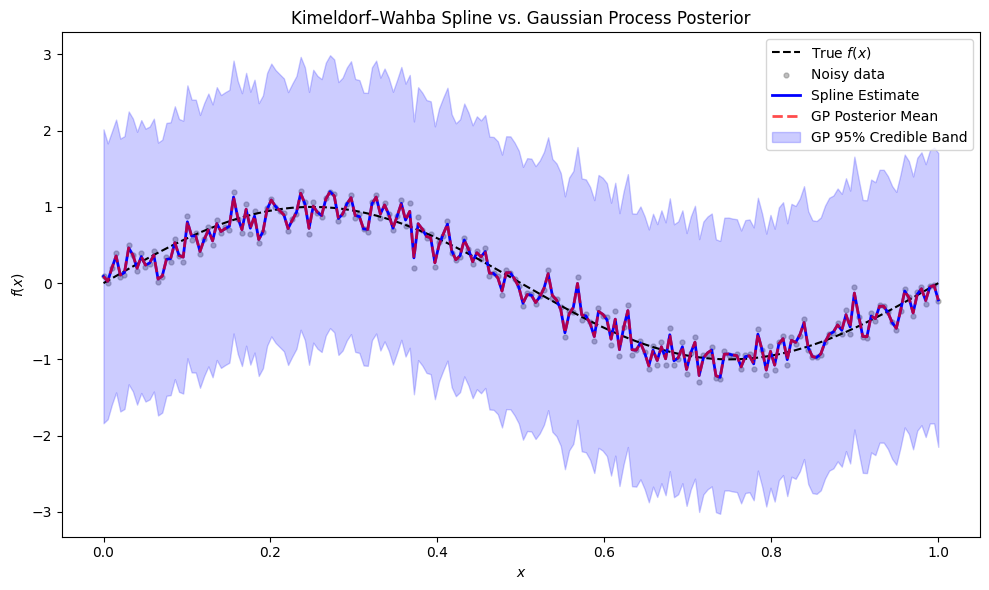

In [5]:
# 4. COMPARISON & VISUALIZATION

print(f"Max |f_spline – f_gp| = {np.max(np.abs(f_spline - f_gp)):.2e} (≈0)\n")

plt.figure(figsize=(10, 6))

# True function and noisy observations
plt.plot(x, f_true, 'k--', label='True $f(x)$')
plt.scatter(x, y, s=12, color='gray', alpha=0.5, label='Noisy data')

# Kimeldorf–Wahba spline (solid) and GP posterior mean (dotted)
plt.plot(
    x,
    f_spline,
    color='blue',
    linestyle='-',
    linewidth=2,
    label='Spline Estimate'
)

plt.plot(
    x,
    f_gp,
    color='red',
    linestyle='--',
    linewidth=2,
    alpha=0.7,
    label='GP Posterior Mean'
)

# 95% credible band from GP posterior covariance
plt.fill_between(
    x,
    f_gp - 1.96 * std_post,
    f_gp + 1.96 * std_post,
    color='blue',
    alpha=0.2,
    label='GP 95% Credible Band'
)

plt.title("Kimeldorf–Wahba Spline vs. Gaussian Process Posterior")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# 5. EIGEN-ANALYSIS & RKHS NORM

# Eigen-decompose P to obtain eigenvalues μᵢ and eigenvectors vᵢ.
# On the non-nullspace (μᵢ>0), Cov_post = (I+λP)⁻¹ has Rayleigh quotients 1/(1 + λ·μᵢ).
# This numerically confirms the penalty ↔ covariance duality.
# Finally, compute fᵀ P f to get the discrete RKHS norm (roughness penalty).

# Eigen-decompose P to confirm its inverse relationship with Cov_post on range(P)
μ, V = la.eigh(P)
mask = μ > 1e-8
μ_pos = μ[mask]
eig_C = np.array([V[:, i].T @ (Cov_post @ V[:, i]) for i in np.where(mask)[0]])

print("First 5 eigenvalue triples (P, 1/P, Cov_post Rayleigh):")
for p_val, c_val in zip(μ_pos[:5], eig_C[:5]):
    print(f"  P: {p_val:.3e},  1/P: {1/p_val:.3e},  Cov_post: {c_val:.3e}")

# Discrete RKHS norm (roughness penalty) of the fitted spline
rkhs_norm = f_spline.T @ (P @ f_spline)
print(f"\nDiscrete RKHS norm fᵀ P f = {rkhs_norm:.5f}")

First 5 eigenvalue triples (P, 1/P, Cov_post Rayleigh):
  P: 3.129e-07,  1/P: 3.196e+06,  Cov_post: 1.000e+00
  P: 2.377e-06,  1/P: 4.207e+05,  Cov_post: 1.000e+00
  P: 9.134e-06,  1/P: 1.095e+05,  Cov_post: 1.000e+00
  P: 2.495e-05,  1/P: 4.008e+04,  Cov_post: 1.000e+00
  P: 5.566e-05,  1/P: 1.796e+04,  Cov_post: 1.000e+00

Discrete RKHS norm fᵀ P f = 21.17569
